# Applying Data Science Model Development (ANN)

## 1. Preprocess the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.3 MB/s eta 0:00:00


In [3]:
# === Step 0: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [5]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("/content/drive/MyDrive/ERP/ANN/Final_dl.csv.gz", compression="gzip")

df

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,accounting_template,dm_gender,wb_category,accounting_template_missing,website_exists,description_exists,duo_bvd_id_exists,dm_gender_missing,capital_usd_missing,shareholders_funds_usd_missing
0,9.447491e+05,0.181549,NaN,-0.003279,3.541786e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
1,1.765783e+04,0.181549,0.098608,0.040249,1.437969e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
2,-2.502728e+04,0.181549,-0.168453,0.040249,1.246335e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,1,1,1,1,0,0
3,1.023630e+03,0.181549,0.020692,0.028005,7.675140e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
4,6.034728e+02,0.181549,0.013782,0.028005,7.037159e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,0.181549,0.188289,0.040249,-7.980458e+03,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,0,0,0,0
477073,-1.343988e+04,-0.028028,-0.004174,0.040249,-1.343954e+04,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,1,0,0,0
477074,-1.027999e+05,0.181549,0.126416,0.040249,-9.145863e+04,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0
477075,-7.534849e+01,-0.024172,0.000283,0.000499,-9.680114e+05,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0


In [6]:
# create a df for classification
df_cls = df.copy()

# drop NaN
df_cls = df_cls.dropna()
df_cls.isna().sum().sum()

np.int64(0)

In [7]:
df_cls

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,accounting_template,dm_gender,wb_category,accounting_template_missing,website_exists,description_exists,duo_bvd_id_exists,dm_gender_missing,capital_usd_missing,shareholders_funds_usd_missing
1,1.765783e+04,0.181549,0.098608,0.040249,1.437969e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
2,-2.502728e+04,0.181549,-0.168453,0.040249,1.246335e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,1,1,1,1,0,0
3,1.023630e+03,0.181549,0.020692,0.028005,7.675140e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
4,6.034728e+02,0.181549,0.013782,0.028005,7.037159e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
5,9.998306e+02,0.181549,0.014539,0.034146,7.002523e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,0.181549,0.188289,0.040249,-7.980458e+03,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,0,0,0,0
477073,-1.343988e+04,-0.028028,-0.004174,0.040249,-1.343954e+04,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,1,0,0,0
477074,-1.027999e+05,0.181549,0.126416,0.040249,-9.145863e+04,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0
477075,-7.534849e+01,-0.024172,0.000283,0.000499,-9.680114e+05,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0


In [8]:
def create_success_flag(df):
    """
    Create a binary 'success' column based on revenue and net income thresholds.
    Drops the original 'revenue_usd' and 'net_income_usd' columns to avoid data leakage.

    A company is considered successful if:
        - revenue_usd > 455.230 (top quartile)
        - net_income_usd > 0 (profitable)

    Parameters:
        df (pd.DataFrame): Input DataFrame containing startup financial data.

    Returns:
        df_new (pd.DataFrame): DataFrame with the added 'success' column and dropped original features.
        success_counts (pd.Series): Count of 0s and 1s in the 'success' column.
    """

    # Make a copy of the original DataFrame to preserve the input
    df_new = df.copy()

    # Define the success condition as a binary indicator
    df_new["success"] = (
        (df_new["revenue_usd"] > 455.230) &
        (df_new["net_income_usd"] > 0)
    ).astype(int)

    # Drop the columns used for creating the target to avoid data leakage
    df_new.drop(columns=["revenue_usd", "net_income_usd"], inplace=True)

    # Count class distribution
    success_counts = df_new["success"].value_counts().sort_index()

    return df_new, success_counts

In [9]:
# create a df for classification
df_class, success_counts = create_success_flag(df_cls)
print(df_class["success"])
print(success_counts)

1         1
2         0
3         1
4         1
5         1
         ..
477072    0
477073    0
477074    0
477075    0
477076    0
Name: success, Length: 476920, dtype: int64
success
0    390252
1     86668
Name: count, dtype: int64


In [10]:
categoricals = ['city', 'country_iso', 'region',
       'legal_form', 'accounting_template', 'dm_gender', 'wb_category',
       'accounting_template_missing', 'website_exists', 'description_exists',
       'duo_bvd_id_exists', 'dm_gender_missing', 'capital_usd_missing',
       'shareholders_funds_usd_missing']

In [11]:
# === CLASSIFICATION: Define target and feature columns ===
target_col_cls = "success"
feature_cols_cls = [col for col in df_class.columns if col != target_col_cls]

# Correct indexing: use feature_cols_reg for alignment
categorical_idxs = [i for i, col in enumerate(feature_cols_cls) if col in categoricals]
numerical_idxs = [i for i, col in enumerate(feature_cols_cls) if col not in categoricals]

# Extract features and target
X_cls = df_class[feature_cols_cls].values  # shape: (samples, features)
y_cls = df_class[target_col_cls].values

# NOTE: For ANN, no need to reshape to (samples, 1, features)

# Split into training, validation, and test sets
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_temp_cls, y_temp_cls, test_size=0.5, random_state=42)

# Define dataset class (still valid for ANN)
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X_categorical = torch.tensor(X[:, categorical_idxs], dtype=torch.long)
        self.X_numeric = torch.tensor(X[:, numerical_idxs], dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categorical[idx], self.X_numeric[idx], self.y[idx]

# Instantiate datasets
train_dataset_cls = ClassificationDataset(X_train_cls, y_train_cls)
val_dataset_cls = ClassificationDataset(X_val_cls, y_val_cls)
test_dataset_cls = ClassificationDataset(X_test_cls, y_test_cls)

# define embedding info
embedding_info = []
for col in categoricals:
    unique_vals = df_class[col].unique()
    max_val = int(max(unique_vals))
    emb_dim = min(50, (max_val + 1 + 1) // 2)
    embedding_info.append((max_val + 1, emb_dim))

## 2. Define the ANN model

In [12]:
# === Step 2: Define ANN (MLP) Model for Classification ===
import torch.nn as nn

class ANNClassifier(nn.Module):
    def __init__(self, num_numeric_features, embedding_info, hidden_size, num_classes, num_layers=1, dropout=0.0):
        super(ANNClassifier, self).__init__()

        # Embedding layers for each categorical feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories, emb_dim in embedding_info
        ])
        total_emb_dim = sum([emb_dim for _, emb_dim in embedding_info])
        input_size = total_emb_dim + num_numeric_features

        # MLP layers
        layers = []
        in_features = input_size
        for _ in range(num_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_features = hidden_size

        layers.append(nn.Linear(hidden_size, num_classes))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x_cat, x_num):
        # Embedding lookup and concatenate with numeric features
        x_emb = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x_emb + [x_num], dim=1)
        return self.model(x)  # logits (no softmax)

## 3. Tune hyperparameters by Optuna

In [ ]:
# === Step 3: Optuna Hyperparameter Tuning for Classification (MLP-based ANN) ===
def objective_cls(trial):
    # Suggest hyperparameters for MLP
    hidden_size = trial.suggest_int("hidden_size", 64, 256)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    n_layers = trial.suggest_int("n_layers", 1, 3)

    # Prepare data loaders
    train_loader = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset_cls, batch_size=batch_size)

    # Create MLP model
    model = ANNClassifier(
        num_numeric_features=len(numerical_idxs),
        embedding_info=embedding_info,
        hidden_size=128,
        num_classes=2,
        num_layers=2,
        dropout=0.3
        )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(10):
        model.train()
        for x_cat, x_num, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x_cat, x_num)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for x_cat, x_num, y in val_loader:
            outputs = model(x_cat, x_num)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y.cpu().numpy())

    # Optuna minimizes, so return (1 - f1_score)
    return 1 - f1_score(y_true, y_pred, average="weighted")

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective_cls, n_trials=20)

best_params_cls = study.best_trial.params
print("Best hyperparameters:", best_params_cls)

[I 2025-06-22 23:54:54,416] A new study created in memory with name: no-name-dde1b5df-4a77-4ee6-aeaf-bbcb9f3524c2
[I 2025-06-23 00:05:18,576] Trial 0 finished with value: 0.1928950731613861 and parameters: {'hidden_size': 70, 'dropout': 0.14629299918336536, 'lr': 0.00029208598960102627, 'batch_size': 64, 'n_layers': 1}. Best is trial 0 with value: 0.1928950731613861.
[I 2025-06-23 00:10:45,505] Trial 1 finished with value: 0.1832648381575228 and parameters: {'hidden_size': 147, 'dropout': 0.46905721881187584, 'lr': 0.003947213359791914, 'batch_size': 128, 'n_layers': 1}. Best is trial 1 with value: 0.1832648381575228.
[I 2025-06-23 00:29:37,305] Trial 2 finished with value: 0.18790895410982944 and parameters: {'hidden_size': 133, 'dropout': 0.1966895649176192, 'lr': 0.0018879203995727796, 'batch_size': 32, 'n_layers': 3}. Best is trial 1 with value: 0.1832648381575228.
[I 2025-06-23 00:38:01,601] Trial 3 finished with value: 0.19678944369318851 and parameters: {'hidden_size': 250, 'dro

Best hyperparameters: {'hidden_size': 147, 'dropout': 0.46905721881187584, 'lr': 0.003947213359791914, 'batch_size': 128, 'n_layers': 1}


## 4. Re-learn with the optimized parameters

In [14]:
# === Step 4: Train Final MLP Model with Best Params (Classification) ===

from sklearn.metrics import roc_auc_score

# rebuild the model
model = ANNClassifier(
    num_numeric_features=len(numerical_idxs),
    embedding_info=embedding_info,
    hidden_size=best_params_cls['hidden_size'],
    num_classes=2,
    num_layers=best_params_cls['n_layers'],
    dropout=best_params_cls['dropout']
)

# loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params_cls['lr'])

# DataLoader
batch_size = best_params_cls['batch_size']
train_loader = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_cls, batch_size=batch_size)

# Initialize lists to store loss values
train_losses = []
val_losses = []
val_aucs = []

# Early stopping variables
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
best_val_auc = 0.0
epochs_no_improve_loss = 0
epochs_no_improve_auc = 0

for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for x_cat, x_num, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x_cat, x_num)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    predicted_labels = []
    prob_0 = []
    prob_1 = []
    y_true_all = []

    with torch.no_grad():
        for x_cat, x_num, y in val_loader:
            outputs = model(x_cat, x_num)
            probs = torch.softmax(outputs, dim=1)

            loss = criterion(outputs, y)
            running_val_loss += loss.item()

            y_true_all.extend(y.cpu().numpy())
            prob_0.extend(probs[:, 0].cpu().numpy())
            prob_1.extend(probs[:, 1].cpu().numpy())

            predicted_labels.extend(torch.argmax(probs, dim=1).cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_auc = roc_auc_score(y_true_all, prob_1)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}")

    # Early stopping on AUC
    if val_auc - min_delta > best_val_auc:
        best_val_auc = val_auc
        epochs_no_improve_auc = 0
        best_model_state_auc = model.state_dict()
    else:
        epochs_no_improve_auc += 1

    # Early stopping on loss
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve_loss = 0
        best_model_state_loss = model.state_dict()
    else:
        epochs_no_improve_loss += 1

    # Combined stopping condition
    if epochs_no_improve_auc >= patience and epochs_no_improve_loss >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Optionally load best model state
model.load_state_dict(best_model_state_auc)

Epoch 1 - Train Loss: 0.4054, Val Loss: 0.3957, Val AUC: 0.7427
Epoch 2 - Train Loss: 0.3981, Val Loss: 0.3940, Val AUC: 0.7534
Epoch 3 - Train Loss: 0.3951, Val Loss: 0.3893, Val AUC: 0.7687
Epoch 4 - Train Loss: 0.3901, Val Loss: 0.3837, Val AUC: 0.7855
Epoch 5 - Train Loss: 0.3828, Val Loss: 0.3717, Val AUC: 0.8137
Epoch 6 - Train Loss: 0.3764, Val Loss: 0.3697, Val AUC: 0.8178
Epoch 7 - Train Loss: 0.3708, Val Loss: 0.3662, Val AUC: 0.8341
Epoch 8 - Train Loss: 0.3669, Val Loss: 0.3567, Val AUC: 0.8420
Epoch 9 - Train Loss: 0.3619, Val Loss: 0.3604, Val AUC: 0.8388
Epoch 10 - Train Loss: 0.3589, Val Loss: 0.3590, Val AUC: 0.8439
Epoch 11 - Train Loss: 0.3570, Val Loss: 0.3575, Val AUC: 0.8449
Epoch 12 - Train Loss: 0.3545, Val Loss: 0.3563, Val AUC: 0.8466
Epoch 13 - Train Loss: 0.3519, Val Loss: 0.3575, Val AUC: 0.8532
Epoch 14 - Train Loss: 0.3512, Val Loss: 0.3529, Val AUC: 0.8546
Epoch 15 - Train Loss: 0.3501, Val Loss: 0.3505, Val AUC: 0.8532
Epoch 16 - Train Loss: 0.3490, Val

<All keys matched successfully>

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


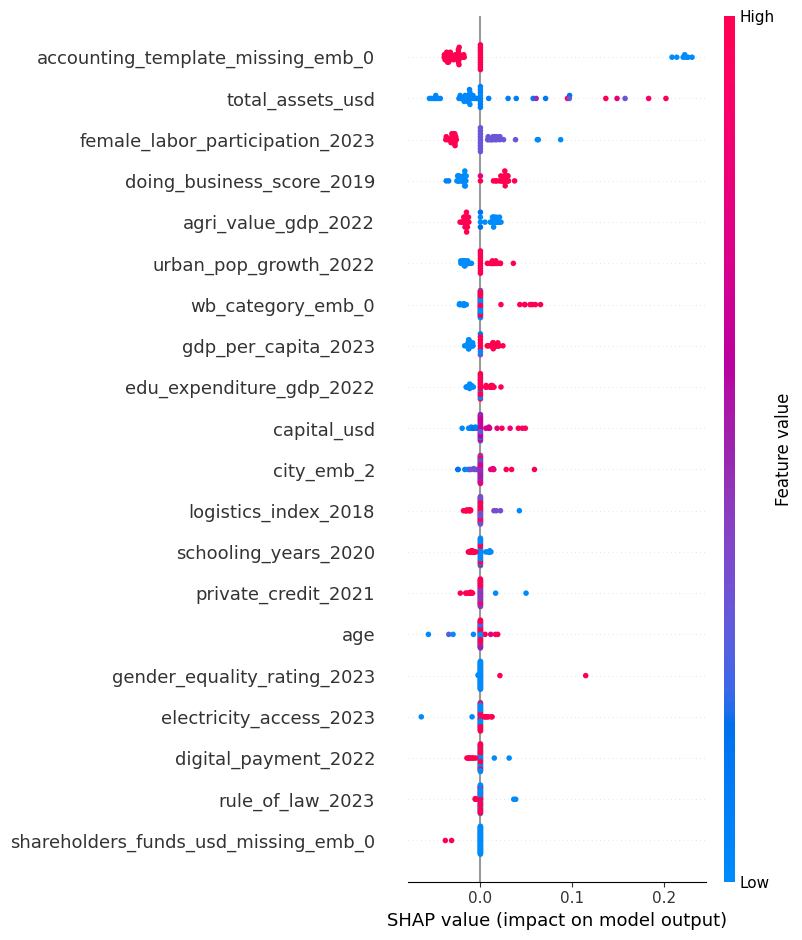

In [ ]:
import shap
import torch.nn.functional as F

# 1. Embed categorical features using the model's embedding layers
with torch.no_grad():
    embedded_values = []
    embedded_feature_names = []

    for i, emb in enumerate(model.embeddings):
        emb_matrix = emb.weight.cpu().numpy()  # [num_categories, emb_dim]
        embedded = emb_matrix[x_cat[:, i]]  # [n_samples, emb_dim]
        embedded_values.append(embedded)

        # Create feature names for each embedding dimension
        var_name = categoricals[i]  # e.g., "region"
        emb_dim = emb_matrix.shape[1]
        embedded_feature_names.extend([f"{var_name}_emb_{j}" for j in range(emb_dim)])

# 2. Concatenate all embeddings and numeric features
X_embedded = np.concatenate(embedded_values, axis=1)  # [n_samples, total_emb_dim]
X_numeric = x_num.numpy()  # [n_samples, num_numeric_features]
X_all = np.concatenate([X_embedded, X_numeric], axis=1)  # [n_samples, total_features]

# 3. Redefine model prediction function that only uses combined input
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model.model(X_tensor)
        probs = F.softmax(logits, dim=1)  # shape: (n_samples, num_classes)
        return probs[:, 1].numpy()  # ← class 1

# 4. SHAP background and explanation data
background_data = X_all[:100]
explanation_data = X_all[:50]

# 5. Run KernelExplainer
explainer = shap.KernelExplainer(model_predict, background_data)
shap_values = explainer.shap_values(explanation_data)

# 6. Construct full feature name list
feature_cols_numeric = [feature_cols_cls[i] for i in numerical_idxs]
feature_names = embedded_feature_names + feature_cols_numeric

# 7. Save results to CSV
pd.DataFrame(shap_values, columns=feature_names).to_csv("shap_values_ann_cls_full.csv", index=False)
pd.DataFrame(explanation_data, columns=feature_names).to_csv("shap_input_ann_cls_full.csv", index=False)

# 8. SHAP summary plot
shap.summary_plot(shap_values, features=explanation_data, feature_names=feature_names)

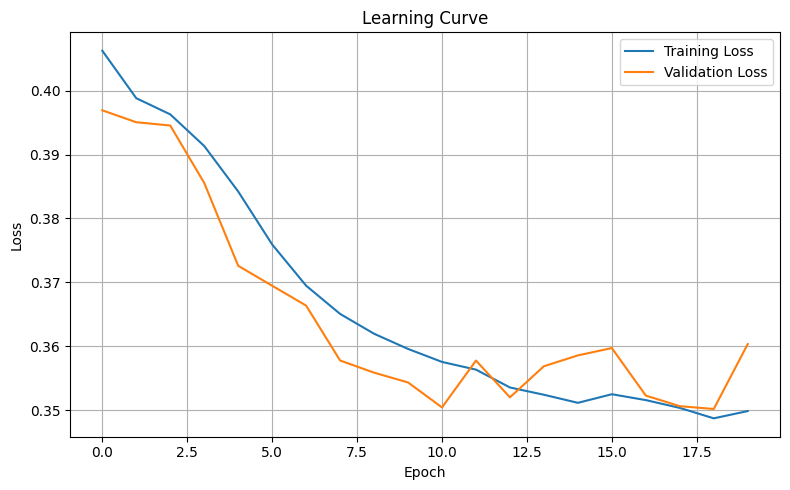

In [ ]:
# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Combine everything into a nice table
results_cls_df = pd.DataFrame({
    "true_label": y_val_cls,
    "predicted_label": predicted_labels,
    "probability_0": prob_0,   # loan_status = 0
    "probability_1": prob_1    # loan_status = 1
})

# Preview
results_cls_df.to_csv("classification_results.csv")
results_cls_df

,true_label,predicted_label,probability_0,probability_1
0,0,0,0.994608,5.392472e-03
1,0,0,1.000000,3.398429e-21
2,0,0,0.590024,4.099762e-01
3,0,0,0.816079,1.839210e-01
4,0,0,1.000000,1.253761e-20
...,...,...,...,...
71533,0,0,0.904280,9.572050e-02
71534,1,0,0.692390,3.076096e-01
71535,0,0,0.958449,4.155110e-02
71536,0,0,0.931887,6.811275e-02


## 5. Evaluate the model


--- Evaluation on Training Data ---
AUC-ROC:     0.8742
F1-Score:    0.5821
Precision:   0.4940
Recall:      0.7086
Confusion Matrix:
[[229073  44064]
 [ 17691  43016]]
Mean G-Mean: 0.7709


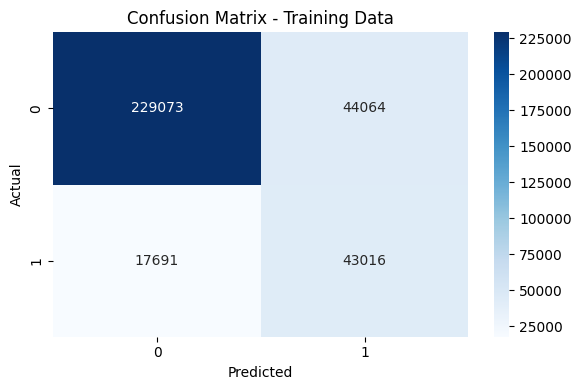


--- Evaluation on Validation Data ---
AUC-ROC:     0.8612
F1-Score:    0.5646
Precision:   0.4758
Recall:      0.6940
Confusion Matrix:
[[48579  9948]
 [ 3981  9030]]
Mean G-Mean: 0.7590


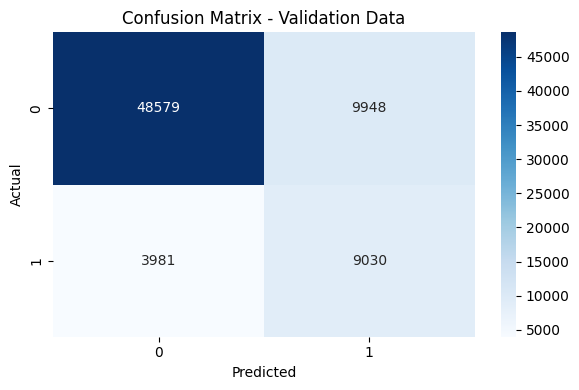


--- Evaluation on Test Data ---
AUC-ROC:     0.8638
F1-Score:    0.5658
Precision:   0.4769
Recall:      0.6954
Confusion Matrix:
[[48710  9878]
 [ 3944  9006]]
Mean G-Mean: 0.7604


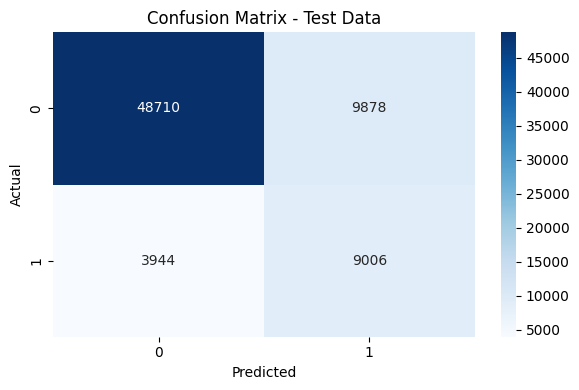

In [15]:
# === Step 5: Evaluation Metrics ===
test_loader = DataLoader(test_dataset_cls, batch_size=batch_size)

def evaluate_model(model, data_loader, dataset_name="", threshold=0.3):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for x_cat, x_num, y_batch in data_loader:
            outputs = model(x_cat, x_num)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = (probs > threshold).int()

            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.numpy())
            y_prob.extend(probs.numpy())

    # Compute metrics
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Compute G-mean
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)
    gmean = np.sqrt(tpr * tnr)

    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Mean G-Mean: {gmean:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Run on both datasets
evaluate_model(model, train_loader, "Training Data")
evaluate_model(model, val_loader, "Validation Data")
evaluate_model(model, test_loader, "Test Data")


--- Evaluation on Test Data @ 0.3 ---
AUC-ROC:     0.8531
F1-Score:    0.5403
Precision:   0.4472
Recall:      0.6825
Confusion Matrix:
[[47663 10925]
 [ 4112  8838]]
Mean G-Mean: 0.7451


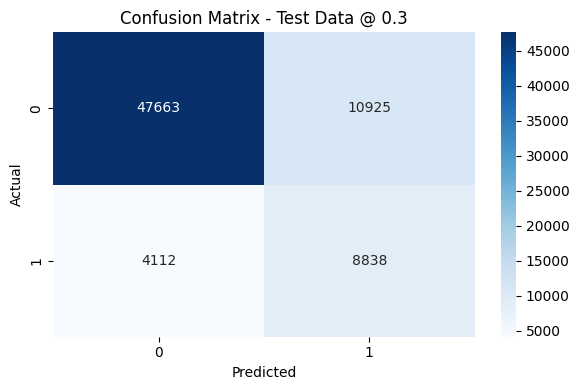


--- Evaluation on Test Data @ 0.5 ---
AUC-ROC:     0.8531
F1-Score:    0.0967
Precision:   0.5656
Recall:      0.0529
Confusion Matrix:
[[58062   526]
 [12265   685]]
Mean G-Mean: 0.2290


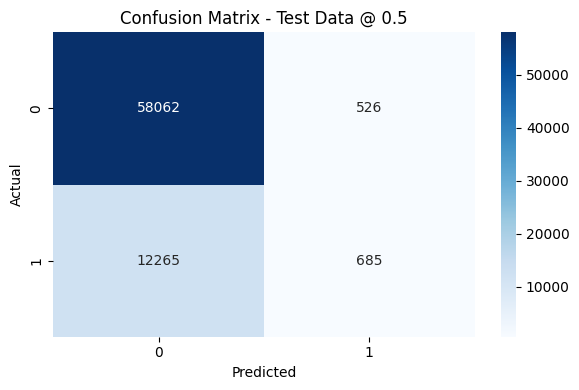


--- Evaluation on Test Data @ 0.1 ---
AUC-ROC:     0.8531
F1-Score:    0.5188
Precision:   0.3598
Recall:      0.9293
Confusion Matrix:
[[37174 21414]
 [  915 12035]]
Mean G-Mean: 0.7679


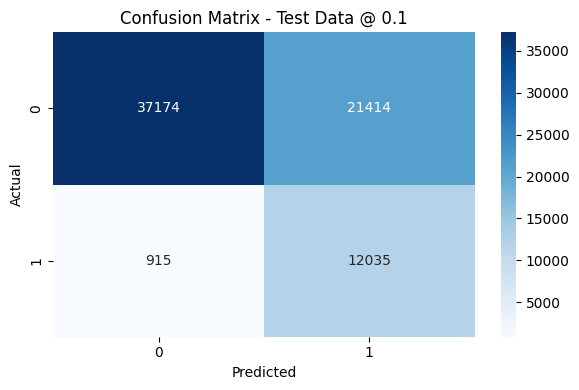

In [ ]:
# Run on test set with different thresholds
evaluate_model(model, test_loader, "Test Data @ 0.3", threshold=0.3)
evaluate_model(model, test_loader, "Test Data @ 0.5", threshold=0.5)
evaluate_model(model, test_loader, "Test Data @ 0.1", threshold=0.1)

## 6. Save the model

In [ ]:
# === Step 6: Save Model and Scaler ===
# Save both model weights and best_params dictionary
torch.save({
    'model_state_dict': model.state_dict(),
    'model_params': best_params_cls
}, "ANN_cls_model_full.pth")

# Convert dict to DataFrame (1 row)
params_df = pd.DataFrame([best_params_cls])

# Save to CSV
params_df.to_csv("best_params_cls.csv", index=False)

# Save scaler used for input normalization
#joblib.dump(scaler, "scaler.pkl")

## Optional: load the model

In [ ]:
'''
# === Optional: Load Model and Scaler Later ===
# Read CSV back into dict
loaded_params_df = pd.read_csv("best_params.csv")
best_params_cls = loaded_params_df.iloc[0].to_dict()

# Convert float strings to actual int if needed
# (because CSV stores all as float by default)
best_params_cls['hidden_size'] = int(best_params_cls['hidden_size'])
best_params_cls['num_layers'] = int(best_params_cls['num_layers'])
best_params_cls['batch_size'] = int(best_params_cls['batch_size'])
'''

In [13]:
# 1. load file
checkpoint = torch.load("/content/drive/MyDrive/ERP/ANN/ANN_cls_model_full.pth", map_location='cpu')

# 2. load contents
state_dict = checkpoint['model_state_dict']
best_params_cls = checkpoint['model_params']